In [2]:
# --- Instalacija Keras Tuner-a ---
!pip install keras-tuner --quiet
!pip install anvil-uplink

# --- Uvoz potrebnih biblioteka ---
import pickle
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_tuner.tuners import RandomSearch

import anvil.server
import io
import anvil.media

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.5/124.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 4.4 MB/s eta 0:00:00


Analiza dataset-a

Train: 34799
Valid: 4410
Test: 12630
Ukupno: 51839
Dimenzije slika: (32, 32, 3)
Broj klasa: 43
Broj instanci po klasama: Counter({np.uint8(2): 2010, np.uint8(1): 1980, np.uint8(13): 1920, np.uint8(12): 1890, np.uint8(38): 1860, np.uint8(10): 1800, np.uint8(4): 1770, np.uint8(5): 1650, np.uint8(25): 1350, np.uint8(9): 1320, np.uint8(7): 1290, np.uint8(3): 1260, np.uint8(8): 1260, np.uint8(11): 1170, np.uint8(35): 1080, np.uint8(18): 1080, np.uint8(17): 990, np.uint8(31): 690, np.uint8(14): 690, np.uint8(33): 599, np.uint8(26): 540, np.uint8(15): 540, np.uint8(28): 480, np.uint8(23): 450, np.uint8(30): 390, np.uint8(16): 360, np.uint8(34): 360, np.uint8(6): 360, np.uint8(36): 330, np.uint8(22): 330, np.uint8(40): 300, np.uint8(20): 300, np.uint8(39): 270, np.uint8(21): 270, np.uint8(29): 240, np.uint8(24): 240, np.uint8(41): 210, np.uint8(42): 210, np.uint8(32): 210, np.uint8(27): 210, np.uint8(37): 180, np.uint8(19): 180, np.uint8(0): 180})
0 255


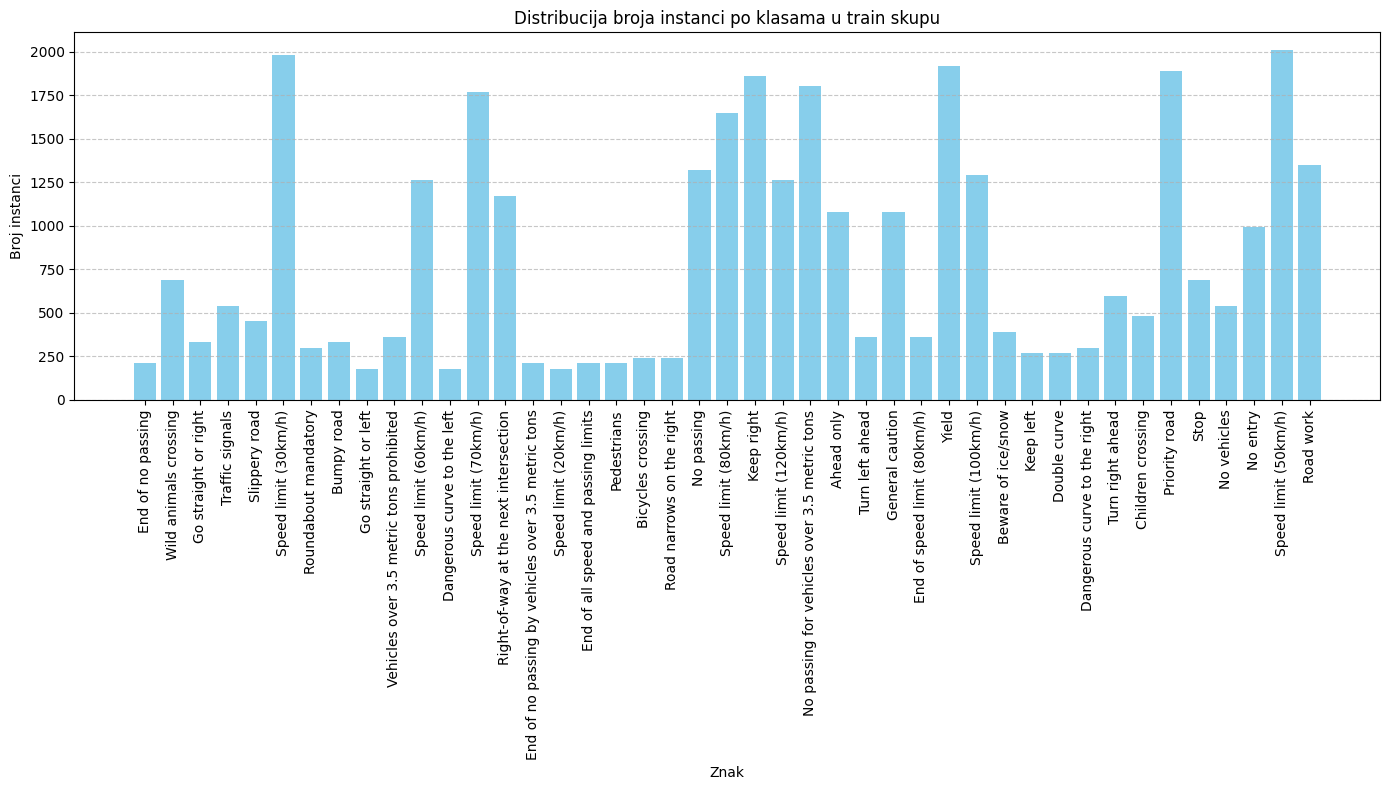

In [ ]:
# Funkcija za učitavanje podataka
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

# Učitavanje train/valid/test
train_data = load_pickle('train.pickle')
valid_data = load_pickle('valid.pickle')
test_data = load_pickle('test.pickle')

X_train, y_train = train_data['features'], train_data['labels']
X_valid, y_valid = valid_data['features'], valid_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

# Broj instanci
print("Train:", X_train.shape[0])
print("Valid:", X_valid.shape[0])
print("Test:", X_test.shape[0])
print("Ukupno:", X_train.shape[0] + X_valid.shape[0] + X_test.shape[0])

print("Dimenzije slika:", X_train.shape[1:])

broj_klasa = len(set(y_train))
print("Broj klasa:", broj_klasa)

train_counts = Counter(y_train)
print("Broj instanci po klasama:", train_counts)

print(X_train.min(), X_train.max())

# Prikaz histograma broja instanci po klasama


# Učitaj nazive znakova
label_df = pd.read_csv('label_names.csv')
id_to_name = dict(zip(label_df['ClassId'], label_df['SignName']))

# Prikaz histograma s nazivima znakova
labels = list(train_counts.keys())
counts = list(train_counts.values())
sign_names = [id_to_name[label] for label in labels]

plt.figure(figsize=(14, 8))
plt.bar(sign_names, counts, color='skyblue')
plt.xlabel('Znak')
plt.ylabel('Broj instanci')
plt.title('Distribucija broja instanci po klasama u train skupu')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Implementacija modela

Broj trening primjera: 34799
Dimenzije slike: (32, 32, 3)
Broj klasa: 43



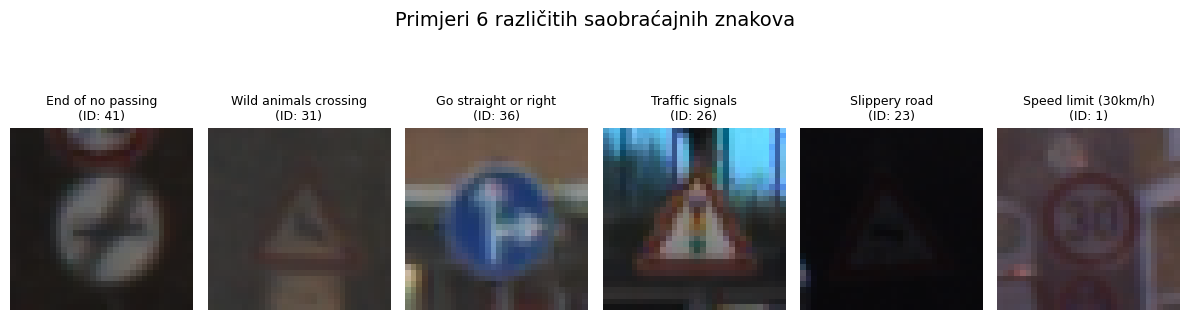

In [ ]:
# --- Učitavanje pickle podataka ---
def load_data_inspect(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data

train_data = load_data_inspect('/content/train.pickle')
valid_data = load_data_inspect('/content/valid.pickle')
test_data = load_data_inspect('/content/test.pickle')

X_train, y_train = train_data['features'], train_data['labels']
X_valid, y_valid = valid_data['features'], valid_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

# --- Informacije ---
print(f"Broj trening primjera: {len(X_train)}")
print(f"Dimenzije slike: {X_train.shape[1:]}")
print(f"Broj klasa: {len(np.unique(y_train))}\n")

# --- Imena klasa ---
signnames = pd.read_csv('/content/label_names.csv')
label_dict = dict(zip(signnames['ClassId'], signnames['SignName']))

# --- Funkcija za prikaz slika ---
def prikazi_primjere_slika(X, y, label_dict, broj_klasa=6):
    samples_per_class = {}
    for i in range(len(y)):
        label = y[i]
        if label not in samples_per_class:
            samples_per_class[label] = i
        if len(samples_per_class) >= broj_klasa:
            break
    plt.figure(figsize=(12, 4))
    for i, (label, idx) in enumerate(samples_per_class.items()):
        plt.subplot(1, broj_klasa, i + 1)
        plt.imshow(X[idx])
        plt.title(f"{label_dict[label]}\n(ID: {label})", fontsize=9)
        plt.axis('off')
    plt.suptitle(f"Primjeri {broj_klasa} različitih saobraćajnih znakova", fontsize=14)
    plt.tight_layout()
    plt.show()

prikazi_primjere_slika(X_train, y_train, label_dict, broj_klasa=6)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,715 (455.92 KB)

 Trainable params: 116,011 (453.17 KB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/80
544/544 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.0526 - loss: 5.1026 - val_accuracy: 0.1651 - val_loss: 4.0371 - learning_rate: 1.0000e-04
Epoch 2/80
544/544 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1551 - loss: 3.9693 - val_accuracy: 0.2469 - val_loss: 3.3252 - learning_rate: 1.0000e-04
Epoch 3/80
544/544 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.2509 - loss: 3.3781 - val_accuracy: 0.3882 - val_loss: 2.7194 - learning_rate: 1.0000e-04
Epoch 4/80
544/544 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3273 - loss: 2.9327 - val_accuracy: 0.4274 - val_loss: 2.4109 - learning_rate: 1.0000e-04
Epoch 5/80
544/544 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3918 - loss: 2.5943 - val_accuracy: 0.4753 - val_loss: 2.1013 - learning_rate: 1.0000e-04
Epoch 6/80
544/544 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4548 - loss: 2.3024 - val_accuracy: 0.5531 - val_loss: 1.8686 - learning_rate: 1.0000e-04
Epoch 7/80
544/544 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy


Test tačnost: 0.9762

Test gubitak: 0.1619
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
ID predviđene klase: 16
Ime klase: Vehicles over 3.5 metric tons prohibited
Pouzdanost: 1.00


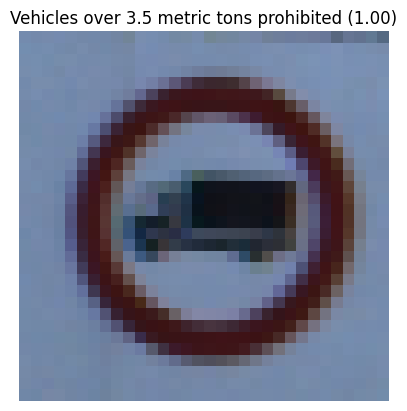

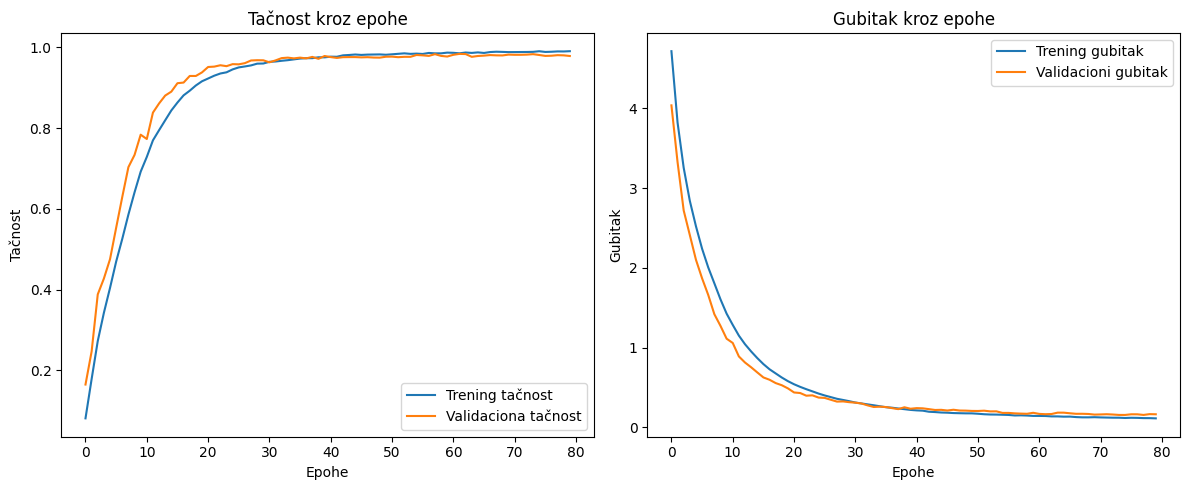

In [ ]:
# --- Normalizacija ---
X_train = X_train.astype('float32') / 255.0
X_valid = X_valid.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# --- One-hot encoding ---
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes)
y_valid_cat = to_categorical(y_valid, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# --- Dimenzije slike ---
img_height, img_width = X_train.shape[1], X_train.shape[2]

# --- Definicija modela ---
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.002), input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.002)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.002)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    GlobalAveragePooling2D(),

    Dense(128, activation='relu', kernel_regularizer=l2(0.002)),
    BatchNormalization(),
    Dropout(0.6),

    Dense(num_classes, activation='softmax')
])

# --- Kompajliranje ---
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# --- Callbackovi ---
earlystop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4)

# --- Treniranje modela ---
history = model.fit(
    X_train, y_train_cat,
    epochs=80,
    batch_size=64,
    validation_data=(X_valid, y_valid_cat),
    callbacks=[earlystop, reduce_lr],
    shuffle=True
)

# --- Evaluacija na test skupu ---
test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print(f"\nTest tačnost: {test_acc:.4f}")
print(f"\nTest gubitak: {test_loss:.4f}")

# --- Učitavanje labela (naziva klasa) ---
signnames = pd.read_csv('/content/label_names.csv')
label_dict = dict(zip(signnames['ClassId'], signnames['SignName']))

model.save('/content/traffic_sign_model.h5')

# --- Predikcija slike ---
from tensorflow.keras.preprocessing import image

def predict_custom_image(img_array):
    img_batch = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_batch)
    class_idx = np.argmax(prediction)
    confidence = prediction[0][class_idx]

    class_name = label_dict.get(class_idx, "Nepoznata klasa")
    print(f"ID predviđene klase: {class_idx}")
    print(f"Ime klase: {class_name}")
    print(f"Pouzdanost: {confidence:.2f}")

    plt.imshow(img_array)
    plt.axis('off')
    plt.title(f"{class_name} ({confidence:.2f})")
    plt.show()

# --- Primjer predikcije ---
predict_custom_image(X_test[0])


# --- Grafički prikaz metrika ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Trening tačnost')
plt.plot(history.history['val_accuracy'], label='Validaciona tačnost')
plt.title('Tačnost kroz epohe')
plt.xlabel('Epohe')
plt.ylabel('Tačnost')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Trening gubitak')
plt.plot(history.history['val_loss'], label='Validacioni gubitak')
plt.title('Gubitak kroz epohe')
plt.xlabel('Epohe')
plt.ylabel('Gubitak')
plt.legend()

plt.tight_layout()
plt.show()


395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        60
           1       0.98      1.00      0.99       720
           2       0.99      0.99      0.99       750
           3       1.00      0.94      0.96       450
           4       1.00      0.98      0.99       660
           5       0.94      1.00      0.97       630
           6       0.99      0.87      0.93       150
           7       1.00      0.97      0.98       450
           8       0.98      0.98      0.98       450
           9       0.99      1.00      0.99       480
          10       0.99      1.00      1.00       660
          11       0.95      1.00      0.98       420
          12       1.00      0.96      0.98       690
          13       1.00      1.00      1.00       720
          14       0.99      1.00      0.99       270
          15       0.92      0.99      0.95       210
          16       1.00      1.00      1

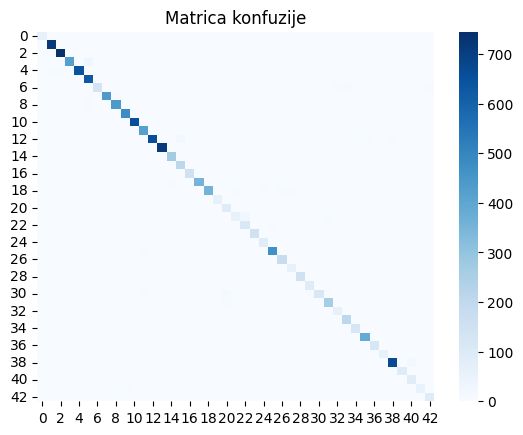

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

print(classification_report(y_true, y_pred_classes))
conf_matrix = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(conf_matrix, annot=False, cmap="Blues")
plt.title("Matrica konfuzije")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
ID predviđene klase: 14
Ime klase: Stop
Pouzdanost: 0.50


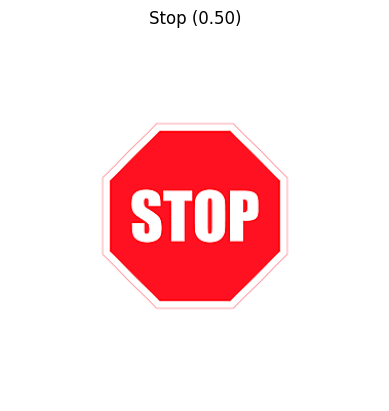

In [ ]:
signnames = pd.read_csv('/content/label_names.csv')
label_dict = dict(zip(signnames['ClassId'], signnames['SignName']))


def predict_custom_image(img_path):
    # Učitavanje i priprema slike
    img = image.load_img(img_path, target_size=(32, 32))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predikcija
    prediction = model.predict(img_array)
    class_idx = np.argmax(prediction)
    confidence = prediction[0][class_idx]

    # Ispis rezultata
    class_name = label_dict.get(class_idx, "Nepoznata klasa")
    print(f"ID predviđene klase: {class_idx}")
    print(f"Ime klase: {class_name}")
    print(f"Pouzdanost: {confidence:.2f}")

    # Prikaz slike
    plt.imshow(image.load_img(img_path))
    plt.axis('off')
    plt.title(f"{class_name} ({confidence:.2f})")
    plt.show()

predict_custom_image("/content/slikaa.png")

Povezivanje modela sa interfejsom

In [ ]:
anvil.server.connect("server_UMKWXQG5TKHPM5H7P54SMUPK-4NLJLM47WDLE2OPT")
# === Učitavanje modela i labela ===
model = load_model('/content/traffic_sign_model.h5')
signnames = pd.read_csv('/content/label_names.csv')
label_dict = dict(zip(signnames['ClassId'], signnames['SignName']))

# === Funkcija za klasifikaciju slike iz Anvil interfejsa ===
@anvil.server.callable
def classify_image(file):
    file_bytes = file.get_bytes()
    img = Image.open(io.BytesIO(file_bytes)).resize((32, 32)).convert('RGB')
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    class_idx = np.argmax(prediction)
    confidence = prediction[0][class_idx]
    class_name = label_dict.get(class_idx, "Nepoznata klasa")

    return f"{class_name} ({confidence:.2f})"

# === Pokretanje servera ===
anvil.server.wait_forever()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
